# Proyecto N°4: Informe Final Carrera

### *Introducción:* 
Para el desarrollo del presente proyecto, se ha optado por continuar lo desarrollado en el Proyecto N°3 correspondiente al análisis de series de tiempo y predicción del flujo vehicular del peaje de la autopista Dr. Arturo Umberto Illia, Buenos Aires, Argentina. 

A través de la implementación de otras técnicas se buscará obtener un modelo cuya capacidad de realizar predicciones sea más elevada que el obtenido en el proyecto antes mencionado. 


### *Objetivo del Proyecto:*
##### "Desarrollar y evaluar un modelo de redes neuronales que permita obtener mayor precisión para predecir el flujo vehicular del último trimestre de 2019 en la autopista Dr. Arturo Umberto Illia, Buenos Aires, Argentina"
***

El siguiente modelo se desarrollará contemplando los siguientes criterios: 
- **Autopista seleccionada:** Autopista Dr. Arturo Umberto Illia.
- **Periodo de tiempo contemplado en la base de datos disponible:** Años 2017 a 2019, inclusive. 
- **Periodo de tiempo a pronosticar:** Último trimestre de 2019. 
- **Filtrado de los datos a realizar:** El modelo será entrenado considerando la cantidad de pasos/cruces realizados por los vehículos que han circulado por la autopista Dr. Arturo U. Illia en ambos sentidos de circulación y que hayan abonado en efectivo. 

##### Estructura del proyecto:

El proyecto se separa en 4 partes: 
- **Parte A:** Análisis Exploratorio de los Datos.
- **Parte B:** Presentación, modelado y evaluación de los modelos de redes neuronales propuestos.
- **Parte C:** Comparación de resultados y conclusiones.

##### Descripción de las columnas del Dataset:
- **periodo**: año del dataset 
- **fecha**: año día mes
- **hora_inicio** hora de inicio de la cuenta de vehículos (DROP)
- **hora_fin** hora de fin de la cuenta de vehículos (Vamos a usar esta para tomar la hora)
- **dia**: día de la semana 
- **estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes había Dellepiane Liniers y Centro, y se agrega PDB)
- **sentido**: Centro o Provincia
- **tipo_vehiculo**: Liviano o Pesado
- **forma_pago**: Hay varias y varían entre los años.
- **cantidad_pasos**: Cantidad de vehículos

#### Repositorio: 
**Link:** https://github.com/gaceballos05/Acamica_DataScienceCareer_Proyecto_4_Series_de_tiempo.git
***
### Librerías por utilizar.

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

import warnings
warnings.filterwarnings('ignore')

### Carga y preparación del dataset 
*Nota: Este código ha sido proporcionado en el Notebook del proyecto y no se ha sido modificado.*

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [3]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


In [4]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


***
### PARTE A: Análisis Exploratorio de los Datos.
A partir del análisis exploratorio llevado a cabo durante el Proyecto N°3 se pudo corroborar que: 


- El dataset contiene los registros de la cantidad de vehículos que han circulado (por día y hora) a través del peaje de la Autopista Dr. Arturo Umberto Illia en el período 2017-2019. Posee cinco (5) columnas. Tres (3) de ellas tienen formato tipo `Series`, mientras que las restantes corresponden a los formatos `int` y `datetime`. Además, tres (3) de ellas son de tipo categóricas por lo cual previamente se las debería transformar para adicionarlas en los modelos a entrenar. 


- La serie de tiempo diaria presenta una serie de valores atípicos. Al filtrar los datos a través del criterio de las 3 sigmas se pudo detectar que:

    - Algunos de los valores atípicos corresponden a registros cuya `cantidad_pasos` figura con valor cero (0). Estos valores serán tratados posteriormente como valores faltantes. 

    - Otros registros poseen un valor superior a cero pero muy inferior a los restantes valores de la serie. Respecto a ellos, se debe destacar que sólo se pudo corroborar que el día 27 de mayo de 2019 se realizó la inauguración del Paseo del Bajo y su empalme, el cual pudo haber afectado drásticamente el flujo vehicular en la autopista bajo análisis durante la realización del acto oficial. Sin embargo, las fechas detectadas no coinciden con esta antes mencionada, por lo cual no fue posible atribuir a estos valores una causa específica (por ejemplo, la disminución en la circulación vehículo por la implementación de obras públicas o medidas de fuerza / huelgas). Ello ha llevado a concluir que los mismos se originaron por una falla al momento de su registro. 


- El dataset no posee fechas faltantes pero sí presenta los valores faltantes antes mencionados.

In [5]:
df_diario = dataset.resample('D', on = 'fecha').sum().reset_index()
df_diario.head(2)

,fecha,cantidad_pasos
0,2017-01-01,31183
1,2017-01-02,51568


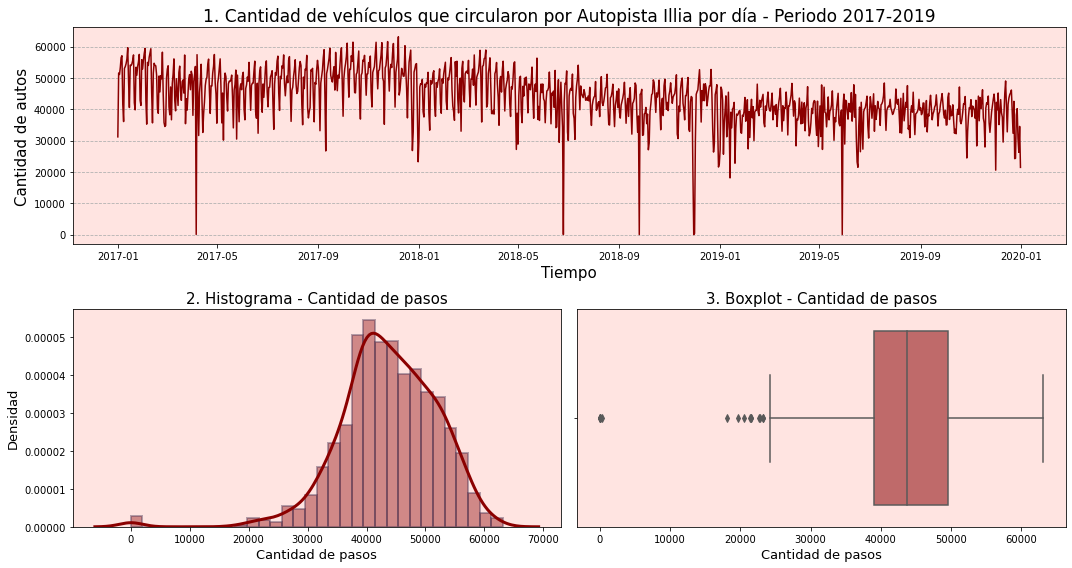

In [6]:
# Comprobar la presencia de valores atípicos.
fig1 = plt.figure(figsize = (15,8))

ax1 = fig1.add_subplot(2,1,1)
ax1.plot(df_diario.fecha, df_diario.cantidad_pasos, color='darkred')
ax1.set_title('1. Cantidad de vehículos que circularon por Autopista Illia por día - Periodo 2017-2019', fontsize = 17)
ax1.set_xlabel('Tiempo', fontsize = 15)
ax1.set_ylabel('Cantidad de autos', fontsize = 15)
ax1.set_facecolor('mistyrose')
ax1.grid(axis = 'y', linestyle='--')

ax2 = fig1.add_subplot(2,2,3)
ax2 = sns.distplot (df_diario.cantidad_pasos, kde_kws = {"color": "darkred", "linewidth": 3}, 
                    hist_kws={"color":"darkred", "linewidth": 2, 
                              "edgecolor" : '#453050'})

ax2.set_title('2. Histograma - Cantidad de pasos', fontsize = 15)
ax2.set_xlabel('Cantidad de pasos', fontsize = 13)
ax2.set_ylabel('Densidad', fontsize = 13)
ax2.set_facecolor('mistyrose')
ax2.ticklabel_format(axis = 'y', useOffset=False, style='plain')

ax3 = fig1.add_subplot(2,2,4)
ax3 = sns.boxplot(df_diario.cantidad_pasos, color = 'indianred')
ax3.set_title('3. Boxplot - Cantidad de pasos', fontsize = 15)
ax3.set_xlabel('Cantidad de pasos', fontsize = 13)
ax3.set_facecolor('mistyrose')

plt.tight_layout()
plt.show()

In [7]:
# Filtrado de valores atípicos considerando el criterio de 3 sigmas.
mean = df_diario.cantidad_pasos.mean()
std = df_diario.cantidad_pasos.std()

umbral_max = mean + 3 * std
umbral_min = mean - 3 * std

print('Umbral Máximo: {max} pasos'.format(max = round(umbral_max)))
print('Umbral Mínimo: {min} pasos'.format(min = round(umbral_min)))

mask = (df_diario.cantidad_pasos < umbral_min) | (df_diario.cantidad_pasos > umbral_max)
df_diario[mask]

Umbral Máximo: 68291 pasos
Umbral Mínimo: 19135 pasos


,fecha,cantidad_pasos
95,2017-04-06,40
540,2018-06-25,0
632,2018-09-25,0
698,2018-11-30,0
699,2018-12-01,350
742,2019-01-13,18076
878,2019-05-29,0


In [8]:
# Comprobar valores nulos sobre el dataset sin resampleo.
print('VALORES FALTANTES')
print(dataset.isnull().sum())
print('-'*50)

# Comprobar si hay fechas faltantes en el dataset resampleado. 
# Nota: El periodo 2017-2019 no posee ningún año bisiesto, por lo cual el dataset debería tener 1095 registros.
df_diario['date_check'] = df_diario.fecha.diff()

print('FECHAS FALTANTES')
print(df_diario.date_check.value_counts())
print('El dataset resampleado posee {d} registros, por lo cual no posee fechas faltantes'.format(d = len(df_diario)))
df_diario = df_diario.drop(['date_check'], axis = 1)

VALORES FALTANTES
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64
--------------------------------------------------
FECHAS FALTANTES
1 days    1094
Name: date_check, dtype: int64
El dataset resampleado posee 1095 registros, por lo cual no posee fechas faltantes


Además se ha detectado que:

- Bajo las condiciones de filtrado, en total han circulado **47.865.581 de vehículos**. De ellos, el **51,62%** han circulado con dirección *Centro*, mientras que los restantes **48,38%** lo han realizado con dirección a *Provincia de Bs As*.

- Se han detectado 2 tipos de unidades en el dataset: vehículos **livianos** y **pesados**. De ellos, la mayor cantidad de vehículos que han circulado por esta autopista corresponden a vehículos *livianos* con el **96,81%** del total. Mientras que el **3,19%** restante ha correspondido a vehículos *pesados*.

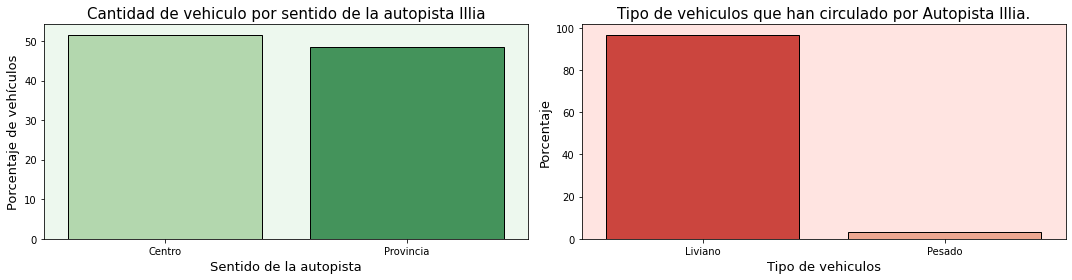

In [9]:
# Sentido de circulación.
flujo_sentido = dataset.groupby('sentido').cantidad_pasos.sum().reset_index()
flujo_sentido['%'] = flujo_sentido['cantidad_pasos'].apply(lambda x: x / float(flujo_sentido.cantidad_pasos.sum())*100)

# Tipo de vehículo.
tipo_vehiculo = dataset.groupby('tipo_vehiculo').cantidad_pasos.sum().reset_index()
tipo_vehiculo ['%'] = tipo_vehiculo['cantidad_pasos'].apply(lambda x: x / float(tipo_vehiculo.cantidad_pasos.sum())*100)

fig2 = plt.figure(figsize = (15,4))
ax1 = fig2.add_subplot(1,2,1)
ax1 = sns.barplot(x='sentido', y='%', data = flujo_sentido, edgecolor = 'black', palette = 'Greens')
ax1.set_title('Cantidad de vehiculo por sentido de la autopista Illia', fontsize = 15)
ax1.set_xlabel('Sentido de la autopista', fontsize = 13)
ax1.set_ylabel('Porcentaje de vehículos', fontsize = 13)
ax1.set_facecolor('#edf8ee')


ax2 = fig2.add_subplot(1,2,2)
ax2 = sns.barplot(x='tipo_vehiculo', y='%', data = tipo_vehiculo, edgecolor = 'black', palette = 'Reds_r')
ax2.set_title('Tipo de vehiculos que han circulado por Autopista Illia.', fontsize = 15)
ax2.set_xlabel('Tipo de vehiculos', fontsize = 13)
ax2.set_ylabel('Porcentaje', fontsize = 13)
ax2.set_facecolor('mistyrose')

plt.tight_layout()
plt.show()

Dentro del análisis exploratorio realizado, también se procedió a analizar la serie de tiempo en búsqueda de patrones para los siguientes casos: 
1. Comportamiento de la serie de tiempo por mes y año.
2. Comportamiento de la serie de tiempo por mes y año considerando el tipo de vehículo que circuló por ella. 
3. Comportamiento de la serie de tiempo de acuerdo con sus sentidos de circulación. 
4. Comportamiento de la serie por día de la semana considerando la cantidad promedio de circulación por tipo de vehículo. 
5. Comportamiento de la serie por día de la semana considerando la cantidad de vehículos total por sentido de circulación.

De estos análisis se procede a destacar y graficar lo realizado en el estudio de la serie de tiempo contemplando su variable tiempo. Es decir, los análisis que contemplaron las variables mes, año y día de la semana correspondientes a los ítems 1, 3 y 4. 

In [10]:
# Cantidad de vehiculos que circularon por mes y año. 
df_año = dataset.copy()
df_año['año'] = df_año['fecha'].dt.year
df_año['mes'] = df_año['fecha'].dt.month

por_año = df_año.groupby(['mes', 'año']).cantidad_pasos.sum().reset_index()
por_año = por_año.pivot(columns = 'año', index = 'mes', values = 'cantidad_pasos').reset_index(drop=True)

# Cantidad de vehiculos que circularon por día de la semana por sentido vehicular. 
por_dia_sentido = dataset.groupby(['sentido','dia']).cantidad_pasos.sum().reset_index()
por_dia_sentido = por_dia_sentido.pivot(columns = 'dia', index = 'sentido', values = 'cantidad_pasos').reset_index()
por_dia_sentido = por_dia_sentido[['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']].T
por_dia_sentido.rename(columns = {0:'Centro', 1:'Provincia'}, inplace = True)
por_dia_sentido['Total'] = por_dia_sentido.Centro + por_dia_sentido.Provincia

# Cantidad de vehiculo promedio por dia de la semana.
circ_semana = dataset.groupby(['dia', 'tipo_vehiculo']).cantidad_pasos.mean().reset_index()
circ_semana_pivot = circ_semana.pivot(columns = 'tipo_vehiculo', 
                                      index = 'dia', 
                                      values = 'cantidad_pasos').reset_index(drop = True)

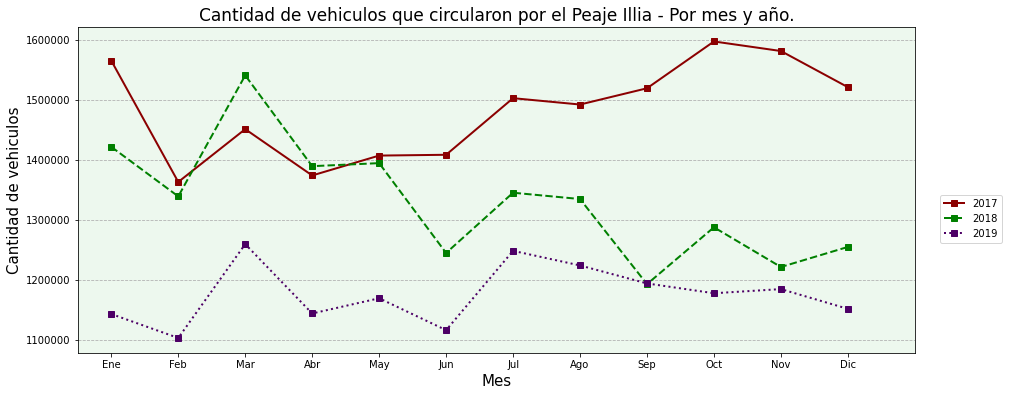

In [11]:
# Gráfico del comportamiento de la serie de tiempo por mes y año.
ax = por_año.plot(style=['-', '--', ':'], linewidth = 2, marker = 's', figsize=(15,6), 
                  color = ['darkred','green', '#4d0066'])
ax.set_xlabel('Mes', fontsize = 15)
ax.set_ylabel('Cantidad de vehiculos', fontsize = 15)
ax.set_title('Cantidad de vehiculos que circularon por el Peaje Illia - Por mes y año.', fontsize = 17)
ax.legend(bbox_to_anchor=(1.11, 0.5))
ax.set_xticks(range(0,12))
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
ax.set_xlim([-0.5,12])
ax.ticklabel_format(axis = 'y', useOffset=False, style='plain')
ax.grid(axis = 'y', linestyle='--')
ax.set_facecolor('#edf8ee')
plt.show()

De esta figura se puede destacar que:

- Se observa que durante el año 2017 la cantidad de vehículos que circularon por esta autopista fue superior a la cantidad de vehículos de los años siguientes. Mientras que la circulación durante el año 2019 ha sido la menor entre los 3 años analizados. Esto puede deberse a los avances que se iban generando en la obra vial del Paseo del Bajo antes mencionada, la cual influyó en la utilización de esta autopista por parte de los clientes. Se debe destacar que la obra vial del Paseo del Bajo se inició el 2 de enero de 2017, previéndose su terminación el 30 agosto de 2019. Es decir, que se puede concluir que esta obra ha influido en el flujo vehicular de la autopista durante todo el periodo bajo análisis.
- Se puede observar que los periodos de Enero-Abril y Julio-Agosto presentan un comportamiento similar pese a la diferencia en la cantidad de flujo vehicular registrado.
- Por último se destaca que los años 2018 y 2019 presentan un patrón de comportamiento similar respecto a la evolución del flujo vehículo mes a mes en comparación con el año 2017.

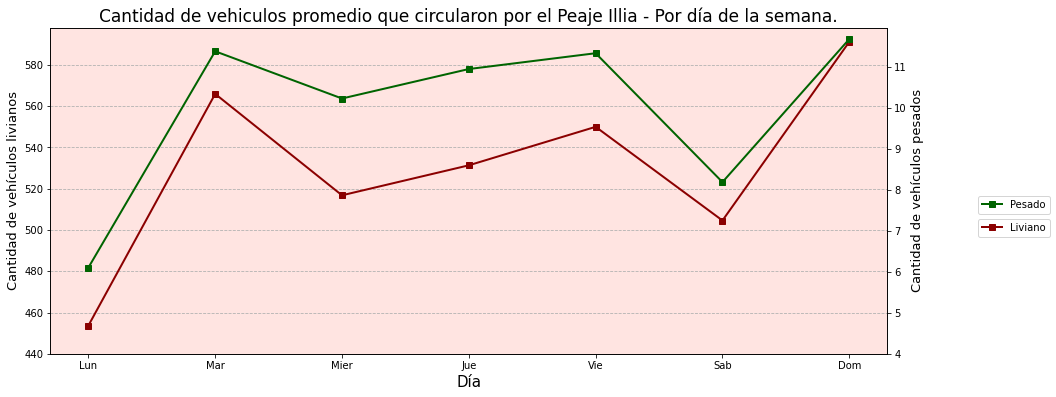

In [12]:
# Gráfico de la cantidad promedio de circulación por tipo de vehículo. por día de la semana
fig5 = plt.figure(figsize = (15, 6))

ax1 = fig5.add_subplot()
ax1.plot(circ_semana_pivot['Liviano'], linewidth = 2, marker = 's', color = 'darkred', label = 'Liviano')
ax1.set_title('Cantidad de vehiculos promedio que circularon por el Peaje Illia - Por día de la semana.', fontsize = 17)
ax1.set_xlabel('Día', fontsize = 15)
ax1.set_ylabel('Cantidad de vehículos livianos', fontsize = 13)
ax1.set_yticks(range(440, 600, 20))
ax1.legend(bbox_to_anchor=(1.2, 0.43))

ax2 = ax1.twinx()
ax2.plot(circ_semana_pivot['Pesado'], linewidth = 2, marker = 's', color = 'darkgreen', label = 'Pesado')
ax2.set_ylabel('Cantidad de vehículos pesados', fontsize = 13)
ax2.set_yticks(range(4, 12, 1))
ax2.legend(bbox_to_anchor=(1.2, 0.5))

ax1.set_xticks(range(0,7))
ax1.set_xticklabels(['Lun', 'Mar', 'Mier', 'Jue', 'Vie', 'Sab', 'Dom'])
ax1.ticklabel_format(axis = 'y', useOffset = False, style = 'plain')
ax1.grid(axis = 'y', linestyle='--')
ax1.set_facecolor('mistyrose')

plt.show()

Respecto a estas series, se puede observar que la cantidad de vehículos livianos y pesados promedio se compartan de manera similar. Esto se observa en el paralelismo que presentan las curvas para cada uno de los días de la semana. La diferencia radica en la cantidad de unidades pesas que circulan entre viernes y domingo. Esto podría coincidir con las restricciones a la circulación de camiones previstas por la Agencia Nacional de Seguridad Vial (ANSV).

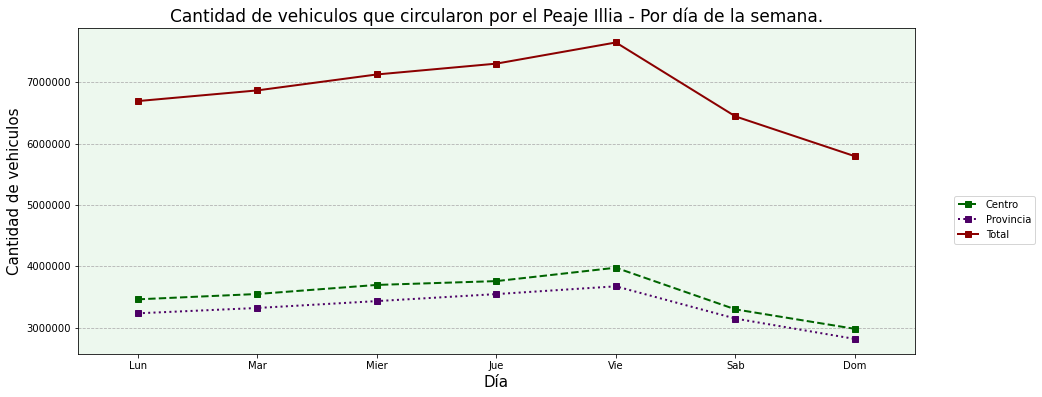

In [13]:
# Grafico de la cantidad de vehículos total por sentido de circulación por día de la semana considerando .
ax = por_dia_sentido.plot(style=['--', ':','-'], linewidth = 2, marker = 's', figsize=(15,6), 
                          color = ['darkgreen', '#4d0066', 'darkred'])
ax.set_xlabel('Día', fontsize = 15)
ax.set_ylabel('Cantidad de vehiculos', fontsize = 15)
ax.set_title('Cantidad de vehiculos que circularon por el Peaje Illia - Por día de la semana.', fontsize = 17)
ax.legend(bbox_to_anchor=(1.15, 0.5))
ax.set_xticks(range(0,7))
ax.set_xlim([-0.5,6.5])
ax.set_xticklabels(['Lun', 'Mar', 'Mier', 'Jue', 'Vie', 'Sab', 'Dom'])
ax.ticklabel_format(axis = 'y', useOffset=False, style='plain')
ax.grid(axis = 'y', linestyle='--')
ax.set_facecolor('#edf8ee')
plt.show()

Al analizar esta última figura:
- Se observa un patrón similar en ambos sentidos de circulación. Aquí, el flujo vehicular se incrementa durante el transcurso de la semana laboral, mientras decrece hacia el fin de semana. 
- Se destaca que el viernes es el día con mayor circulación. Esto puede estar relacionado con la utilización de esta vía por parte de personas que realizan sus actividades laborales en el Centro de la Ciudad de Bs As o zonas aledañas pero residen en áreas con dirección a Provincia de Bs As.

**Preprocesamiento de valores faltantes y nulos**

Ante lo detectado anteriormente respecto a valores atípicos y faltantes, y antes de continuar con el análisis de los componentes de la serie de tiempo, se procederá a convertir los mismos en valores `Nan`y realizar su interpolación.


In [14]:
df_sin_atipicos = df_diario.copy()
df_sin_atipicos[df_sin_atipicos.cantidad_pasos < umbral_min]
df_atipicos = df_sin_atipicos[df_sin_atipicos.cantidad_pasos < umbral_min]
df_atipicos

,fecha,cantidad_pasos
95,2017-04-06,40
540,2018-06-25,0
632,2018-09-25,0
698,2018-11-30,0
699,2018-12-01,350
742,2019-01-13,18076
878,2019-05-29,0


In [15]:
# Se transforman los valores detectados en valores nulos.
df_sin_atipicos.cantidad_pasos[df_sin_atipicos.cantidad_pasos < umbral_min] = np.nan

# Se procede a interporlar los valores nulos.
print(df_sin_atipicos.isna().sum())
print('-'*20)
df_preproc = df_sin_atipicos.interpolate()
print(df_preproc.isna().sum())

fecha             0
cantidad_pasos    7
dtype: int64
--------------------
fecha             0
cantidad_pasos    0
dtype: int64


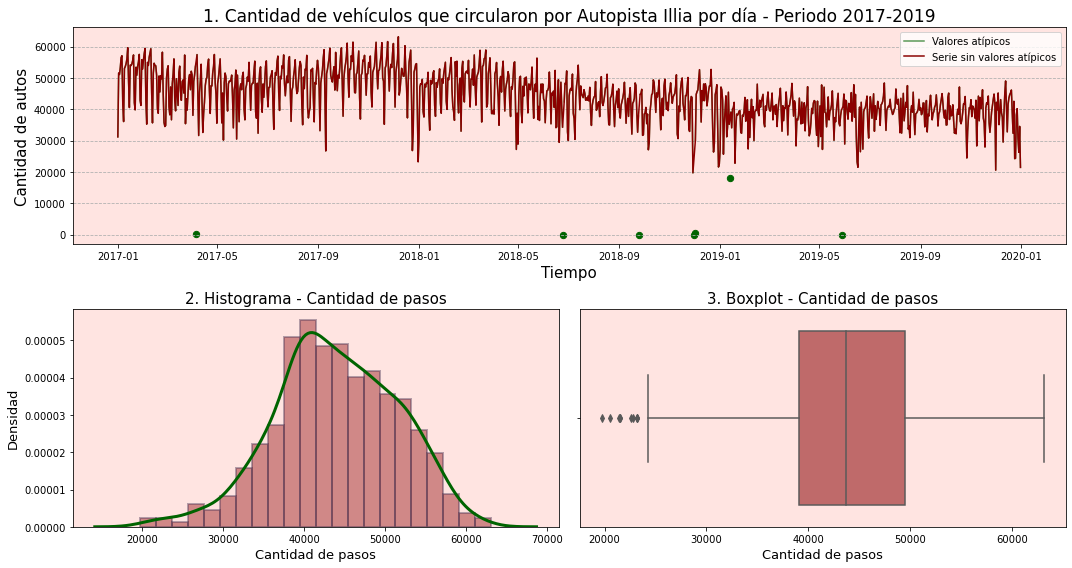

In [16]:
# Gráfico de la serie de tiempo preprocesada.

fig7 = plt.figure(figsize = (15,8))

ax1 = fig7.add_subplot(2,1,1)
ax1.plot(df_sin_atipicos.fecha, df_sin_atipicos.cantidad_pasos, color='darkgreen', alpha = 0.65, label = 'Valores atípicos')
ax1.plot(df_preproc.fecha, df_preproc.cantidad_pasos, color='darkred', label = 'Serie sin valores atípicos')
ax1.scatter(df_atipicos.fecha, df_atipicos.cantidad_pasos, color = 'darkgreen', marker = 'o',s = 40)
ax1.set_title('1. Cantidad de vehículos que circularon por Autopista Illia por día - Periodo 2017-2019', fontsize = 17)
ax1.set_xlabel('Tiempo', fontsize = 15)
ax1.set_ylabel('Cantidad de autos', fontsize = 15)
ax1.legend()
ax1.set_facecolor('mistyrose')
ax1.grid(axis = 'y', linestyle='--')

ax2 = fig7.add_subplot(2,2,3)
ax2 = sns.distplot (df_preproc.cantidad_pasos, kde_kws = {"color": "darkgreen", "linewidth": 3}, 
                    hist_kws={"color":"darkred", "linewidth": 2, 
                              "edgecolor" : '#453050'})

ax2.set_title('2. Histograma - Cantidad de pasos', fontsize = 15)
ax2.set_xlabel('Cantidad de pasos', fontsize = 13)
ax2.set_ylabel('Densidad', fontsize = 13)
ax2.set_facecolor('mistyrose')
ax2.ticklabel_format(axis = 'y', useOffset=False, style='plain')

ax3 = fig7.add_subplot(2,2,4)
ax3 = sns.boxplot(df_preproc.cantidad_pasos, color = 'indianred')
ax3.set_title('3. Boxplot - Cantidad de pasos', fontsize = 15)
ax3.set_xlabel('Cantidad de pasos', fontsize = 13)
ax3.set_facecolor('mistyrose')

plt.tight_layout()
plt.show()

A partir de los gráficos obtenidos luego de las transformaciones realizadas, se puede observar que: 

- La serie ya no presenta las caídas repentinas correspondientes a los valores atípicos detectados.
- En el histograma se ha reducido sustancialmente su sesgo lateral izquierdo.
- El boxplot sigue presentando algunos valores que pueden considerarse como atípicos, pero en una proporción mucho menor. 

Por último, en el análisis exploratorio realizado se procedió a analizar los componentes de la serie de tiempo, su estacionariedad y autocorrelación. 

Dentro del análisis de los **componentes de la serie de tiempo** se pudo alcanzar las siguientes conclusiones: 

- A través del uso del método de la *Media Móvil* y la función `seasonal_descompose`, se observó que: 

    - La serie de tiempo muestra una clara tendencia bajista la cual se asemeja a la media móvil calculada. La misma alcanza un máximo el 23 de octubre de 2017 y, a partir de esa fecha, su pendiente sigue un camino decreciente. Las razones que pudieron llevar a este comportamiento pueden consistir en:
    
        - Una disminución en la cantidad de vehículos que circulan por la autopista Illia debido a las obras de remodelación que se llevan a cabo sobre la misma.
        - Una disminución en la cantidad de clientes que abonan el servicio con efectivo optando por alguna de las otras formas de pago (por ejemplo, tele pase).
        - Otras variables de carácter socioeconómico-ambientales que hayan llevado a la disminución de los vehículos en esta autopista, por ejemplo la caída del poder adquisitivo del salario, la implementación de teletrabajo, la realización de pool de viajes entre colegas, etc.
            
    - No es posible observar si la serie de tiempo es estacional o no. Sin embargo, por lo analizado en apartados anteriores, es posible observar ciertos patrones que se repiten en forma mensual (año a año) y otros de forma semanal (como la diminución en la cantidad de vehículos que circulan los fines de semana).
    
    - Por otro lado, los residuales parecen encontrarse más dispersos en los valores negativos que en los valores positivos, salvo en el último año (2019) donde la distribución parece tomar un comportamiento más aleatorio. Estos valores de aparente distribución aleatoria representan a aquellos elementos que el modelo es incapaz de explicar. Al analizar el histograma realizado sobre los residuales, se observa que los mismos tienden a distribuirse de forma similar a la distribución normal, con una cierta concentración en torno a +/-5000 y con largas colas en ambos sentidos.

In [17]:
# Transformación del indice del dataset:
df_preprocesado = df_preproc.copy()
df_preprocesado = df_preprocesado.set_index(df_preprocesado.fecha)
df_preprocesado = df_preprocesado.drop(['fecha'], axis = 1)

# Media Movil. Definir ventana. 
ventana = int(365/3) # Trimestres.
media_movil = df_preprocesado.cantidad_pasos.rolling(window=ventana, center = True).mean()

# Descomposición de la serie de tiempo.
descomp_serie = seasonal_decompose(df_preprocesado['cantidad_pasos'], model='additive')

In [18]:
df_preprocesado

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0
...,...
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0


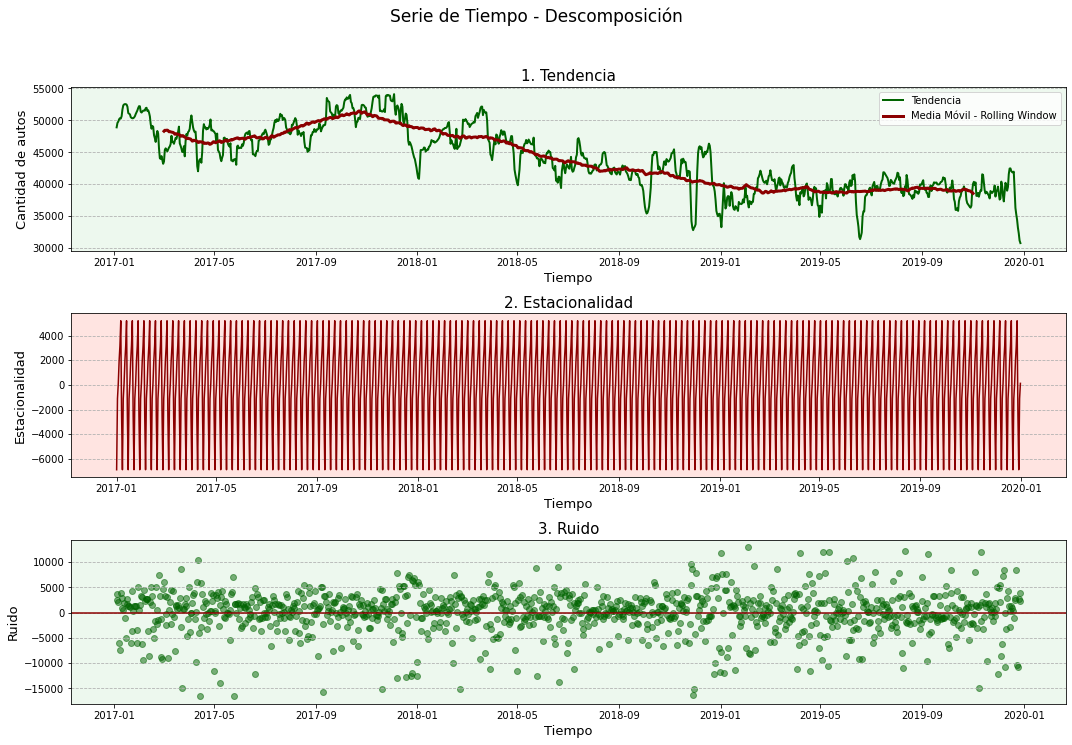

In [19]:
# Descomposición de la serie de tiempo
fig9 = plt.figure(figsize = (15,10))

# Tendencia
ax1 = fig9.add_subplot(3,1,1)
ax1.plot(descomp_serie.trend.index, descomp_serie.trend, color='darkgreen', lw = 2, label = 'Tendencia')
ax1.plot(media_movil, color='darkred', lw = 3, label = 'Media Móvil - Rolling Window')
ax1.set_title('1. Tendencia', fontsize = 15)
ax1.set_xlabel('Tiempo', fontsize = 13)
ax1.set_ylabel('Cantidad de autos', fontsize = 13)
ax1.set_facecolor('#edf8ee')
ax1.grid(axis = 'y', linestyle='--')
ax1.legend()

# Estacionalidad
ax2 = fig9.add_subplot(3,1,2)
ax2.plot(descomp_serie.seasonal.index, descomp_serie.seasonal, color='darkred')
ax2.set_title('2. Estacionalidad', fontsize = 15)
ax2.set_xlabel('Tiempo', fontsize = 13)
ax2.set_ylabel('Estacionalidad', fontsize = 13)
ax2.set_facecolor('mistyrose')
ax2.grid(axis = 'y', linestyle='--')

# Ruido
ax3 = fig9.add_subplot(3,1,3)
ax3.scatter(descomp_serie.resid.index, descomp_serie.resid, color='darkgreen', alpha =0.5)
ax3.axhline(y = 0, color='darkred')
ax3.set_title('3. Ruido', fontsize = 15)
ax3.set_xlabel('Tiempo', fontsize = 13)
ax3.set_ylabel('Ruido', fontsize = 13)
ax3.set_facecolor('#edf8ee')
ax3.grid(axis = 'y', linestyle='--')

plt.suptitle('Serie de Tiempo - Descomposición',y = 1.03, fontsize=17)
plt.tight_layout()
plt.show()

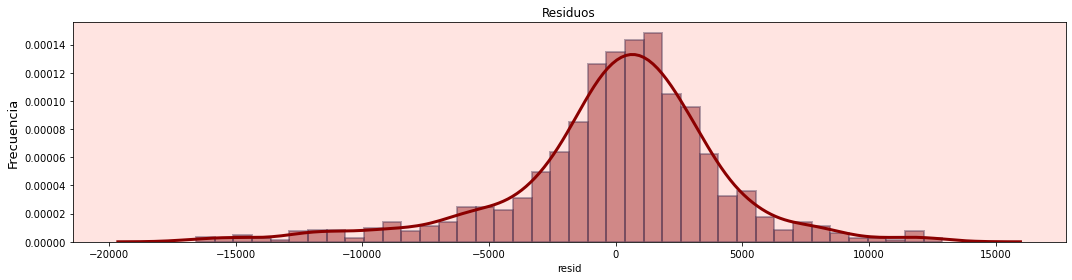

In [20]:
# Histogramas de los residuos de la serie de tiempo.
fig10 = plt.figure(figsize = (15,4))
ax1 = fig10.add_subplot()
ax1 = sns.distplot (descomp_serie.resid, kde_kws = {"color": "darkred", "linewidth": 3}, 
                    hist_kws={"color":"darkred", "linewidth": 2, "edgecolor" : '#453050'})
ax1.set_title('Residuos')
ax1.set_ylabel('Frecuencia', fontsize = 13)
ax1.set_facecolor('mistyrose')
plt.tight_layout()
plt.show()

En lo que concierne a la *prueba de Estacionariedad* y el análisis de *Autocorrelación* en la presente serie de tiempo se pudo concluir que: 
- La serie de tiempo **no** era estacionaria. Es decir que, si se procedería a utilizar un modelo clásico como ARIMA, ARMA o similar, sería necesario realizar una transformación en la serie de tiempo de forma tal que la misma sea estacionaria.
- La autocorrelación era más fuerte respecto con el valor más reciente y disminuía a medida que se incrementa el tiempo del retardo.
- Además, la autocorrelación en su mayoría se observó positiva, variando entre 0 y 0.6, lo que indica que los valores tienden a moverse en forma similar. Sin embargo, a medida que transcurría el tiempo, empiezan a influir otros factores que hacen que los valores no están tan auto correlacionados.
- Por último, se pudo observar que la autocorrelación caía dentro del intervalo de confianza del 95% en un valor cercano a 225 días de retardo (lag).

In [21]:
# Prueba de estacionareidad
estadistico, p_valor, retrasos, n_observaciones, valores_criticos, criterios = adfuller(df_preproc['cantidad_pasos'])

if p_valor < 0.05: 
    print('El p valor asciende a {p} siendo menor que el umbral de significancia del 5%.'.format(p = round(p_valor, 4)))
    print('Se rechaza la hipótesis nula. Por lo tanto: ')
    print('Con un nivel de confianza del 95%, se puede concluir que la serie de tiempo bajo análisis es estacional')
else:
    print('El p valor asciende a {p} siendo mayor que el umbral de significancia del 5%.'.format(p = round(p_valor, 4)))
    print('Se rechaza la hipótesis alternativa. Por lo tanto: ')
    print('Con un nivel de confianza del 95%, se puede concluir que la serie de tiempo bajo análisis NO es estacionaria')

El p valor asciende a 0.4155 siendo mayor que el umbral de significancia del 5%.
Se rechaza la hipótesis alternativa. Por lo tanto: 
Con un nivel de confianza del 95%, se puede concluir que la serie de tiempo bajo análisis NO es estacionaria


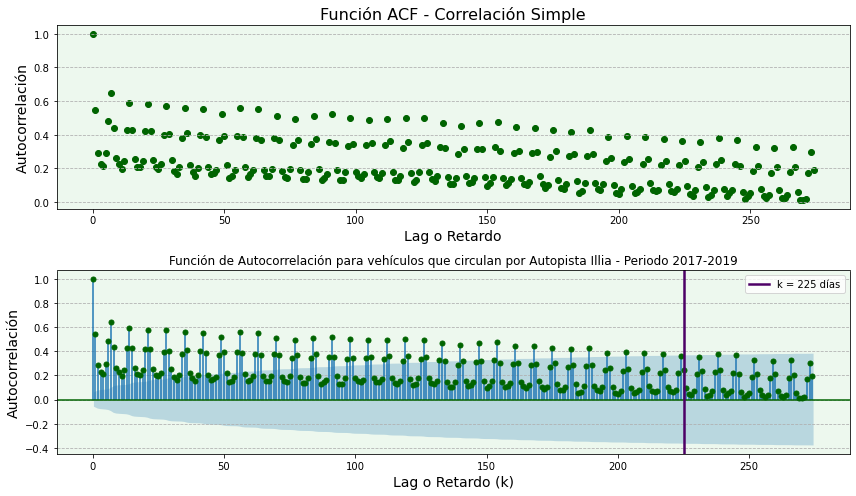

In [22]:
# Función de autocorrelación con un retardo de 365 días.
nlags =  round(len(df_preproc.cantidad_pasos) / 4)

autocorr = acf(df_preproc.cantidad_pasos, nlags = nlags)

fig11 = plt.figure(figsize = (12,7))
ax1 = fig11.add_subplot(2,1,1)
ax1.scatter(np.arange(nlags+1), autocorr, color = 'darkgreen')
ax1.set_xlabel('Lag o Retardo', fontsize = 14)
ax1.set_ylabel('Autocorrelación', fontsize = 14)
ax1.set_title('Función ACF - Correlación Simple', fontsize = 16)
ax1.set_facecolor('#edf8ee')
ax1.grid(axis = 'y', linestyle='--')

ax2 = fig11.add_subplot(2,1,2)
plot_acf(df_preproc.cantidad_pasos, lags = nlags, ax = ax2, color = 'darkgreen')
ax2.axvline(x = 225, c = '#4d0066', lw = 2.5, label = 'k = 225 días')
ax2.set_facecolor('#edf8ee')
ax2.grid(axis = 'y', linestyle='--')
ax2.set_title('Función de Autocorrelación para vehículos que circulan por Autopista Illia - Periodo 2017-2019')
ax2.set_xlabel('Lag o Retardo (k)', fontsize = 14)
ax2.set_ylabel('Autocorrelación', fontsize = 14)
plt.legend()
plt.tight_layout()
plt.show()

### PARTE B: Presentación, modelado y evaluación de los modelos de redes neuronales propuestos.
Durante el Proyecto N°3 se ha creado un modelo `RandomForestRegressor` bajo la estrategia One-Step Prediction. Para ello, utilizando la columna de `cantidad_pasos`, se ha creado un arreglo de entrada que consideraba (para la versión optimizada) la cantidad de vehículos que circularon por el peaje en los 180 días anteriores y generaba como salida la cantidad de vehículos que se estimaba que iban a circular por dicha estación para los últimos 91 días del año 2019. 
De esa manera se alimentó al modelo y éste fue capaz de realizar pronósticos parcialmente aceptables, sólo utilizando la columna de cantidad de vehículos que circularon por dicho peaje.

Ahora, se propone la realización de 2 nuevos modelos utilizando Redes Neuronales Feedforward para intentar mejorar los pronósticos de cantidad de pasos por el peaje Illia para el último trimestre de 2019:

- El primer modelo consistirá en construir una red neuronal MLP (Multilayered Perceptron) feedforward de pocas capas considerando solo la cantidad de pasos como atributo de entrada.
- El segundo modelo consistirá en construir la misma red neuronal que en el modelo anterior considerando la variable categórica fecha como una nueva variable de entrada. Se considera que esta variable puede aportar información valiosa al momento de predecir el flujo vehicular y la red podría aprender sobre la estacionalidad semanal y mensual que posee la serie base.

Se utilizará la arquitectura de red neuronal MLP FeedForward con pocas neuronas y, como método de activación, la tangente hiperbólica dado que se entregarán valores transformados entre -1 y 1.

***
### Aproximación Teórica: 
A continuación, se procede a desarrollar algunos de los conceptos considerados esenciales para el entendimiento de los modelos por desarrollar:

##### - Redes Neuronales: 
Una neurona es una función única que toma entradas y aplica una función de activación. Por consiguiente, se puede definir a los modelos de redes neuronales (Neural Networks) como estructuras formales de carácter matemático y estadístico con la propiedad del aprendizaje, es decir, que tienen la capacidad de adquirir conocimientos que en la mayoría de los casos se obtienen a partir de ejemplos. Este aprendizaje se produce mediante un estilo de computación denominado en paralelo que intenta simular algunas de las capacidades que posee nuestro cerebro. 

##### - Redes neuronales feedforward y perceptrones multicapa:
Este es un tipo de red neuronal artificial en la que las conexiones entre los nodos no forman un ciclo. La red neuronal feedforward fue el primer y más simple tipo de red neuronal artificial ideada. En esta red, la información se mueve en una sola dirección, hacia adelante, desde los nodos de entrada, a través de los nodos ocultos (si los hay) y hacia los nodos de salida. No hay ciclos ni bucles en la red. 

Una red neuronal feedforward, o de retroalimentación, implica capas secuenciales de composiciones de funciones. Cada capa genera un conjunto de vectores que sirven como entrada a la siguiente capa, que es un conjunto de funciones. Hay tres tipos de capas:

- **Capa de entrada:** Corresponde a los datos de entrada sin procesar.
- **Capa/s oculta/s:** Son las secuencias de conjuntos de funciones para aplicar a las entradas o salidas de capas ocultas anteriores
- **Capa de salida:** Función final o conjunto de funciones.

Un perceptrón multicapa es un caso especial de una red neuronal de retroalimentación en la que cada capa es una capa completamente conectada y, en algunas definiciones, el número de nodos en cada capa es el mismo. Además, en muchas definiciones, la función de activación a través de capas ocultas es la misma.

#### Preparación de los datos.
Para poder desarrollar estos modelos será necesario modificar el flujo de entrada del dataset que contiene una columna (`cantidad_pasos`), y se lo convertirá en varias columnas. Esta transformación implica tomar la serie temporal y convertirla en un “problema de tipo supervisado“ para poder alimentar a la red neuronal y poder entrenarla con backpropagation. 

Lo que se procederá a realizar es tomar los 180 días previos para “obtener” el siguiente (es decir, el día 181). Para lograr esta transformación de los datos se utilizará la función `series_to_supervised()` de la web [machinelearningmastery](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) la cual se adjunta a continuación.

Antes de usar la función, se utilizará el `MinMaxScaler` para transformar el rango de los valores entre -1 y 1 para favorecer a la realización de los cálculos de la red neuronal.

In [23]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    """Función que toma una serie de tiempo univariante o multivariante y la enmarca como un conjunto 
    de datos de aprendizaje supervisado. La función toma cuatro argumentos:
    
        - data: Secuencia de observaciones como una lista o matriz 2D NumPy. Requerido.
        - n_in: Número de observaciones de retardo como entrada ( X ). Los valores pueden estar entre 
        [1..len (datos)] Opcional. Por defecto es 1.
        - n_out: Número de observaciones como salida ( y ). Los valores pueden estar entre 
        [0..len (datos) -1]. Opcional. Por defecto es 1.
        - dropnan: booleano para eliminar filas con valores NaN. Opcional. El valor predeterminado es Verdadero.
    
    La función devuelve un solo valor: un DataFrame de series enmarcadas para aprendizaje supervisado con cada 
    columna adecuadamente nombrada tanto por número de variable como por paso de tiempo."""
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Modelo N°1: Serie de Tiempo Univariables (STU) ¶
Como se mencionase anteriormente, se entrenará una *red neuronal MLP (Multilayered Perceptron) feedforward* de pocas capas considerando solo la cantidad de pasos como atributo de entrada.

La arquitectura de la red neuronal será:

- Entrada: 180 inputs. Corresponden a la cantidad de pasos de los 180 días anteriores transformados en un rango entre -1 y 1.
- Capa oculta: 1 nivel con 50 neuronas (valor escogido en forma arbitraria)
- Salida: 1 sola neurona.
- Como función de activación se utilizará la tangente hiperbólica puesto que se utilizan valores entre -1 y 1.

Definido el modelo, se lo compila especificando la función de optimización, la de coste o pérdida y las métricas de evaluación.
- Como optimizador se utilizará Adam ya que es muy útil para la realización de experimentos rápidos.  
- Como métrica de pérdida (loss) se ha seleccionado el Error Cuadrático Medio. 
- Para medir la performance del modelo se utilizará la Raíz del Error Cuadrático Medio (RSME) tal como se ha utilizado para evaluar los modelos del proyecto N°3. Para saber si el modelo mejora con el entrenamiento este se debería ir reduciendo con las EPOCHS.

In [24]:
def crear_red_neuronal():
    """Función para crear una red neuronal con las siguientes características:
    - La instrucción Flatten convierte los elementos de la matriz de entrada en un array plano. 
    - Luego, con la instrucción Dense, añadimos una capa oculta (hidden layer) de la red neuronal. 
    La primera tendrá 50 nodos y la segunda (capa de salida) tendrá 1. 
    - Para la función de activación usaremos en la capa oculta `tanh` correspondiente a la tangente hiperbólica."""
    
    model = Sequential() 
    model.add(Dense(50, input_shape=(1,lookback*variables), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='Adam', 
                  metrics=[RootMeanSquaredError()])
    model.summary()
    return model

#### 1. Transformación de los datos de entrada. 

In [25]:
# Transformación de los datos.  
lookback = 180
variables = 1
values = df_preprocesado.values
values = values.astype('float32')

# Normalización de los valores en el rango (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)

# Aplicamos la función series_to_supervised
reframed = series_to_supervised(scaled, lookback, 1)
reframed.head()

,var1(t-180),var1(t-179),var1(t-178),var1(t-177),var1(t-176),var1(t-175),var1(t-174),var1(t-173),var1(t-172),var1(t-171),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
180,-0.472108,0.467315,0.445425,0.548607,0.693956,0.721376,0.007350,-0.247125,0.534966,0.561004,...,0.307634,0.494366,0.557548,0.080901,-0.109933,0.306251,0.109841,0.328648,0.562156,0.645430
181,0.467315,0.445425,0.548607,0.693956,0.721376,0.007350,-0.247125,0.534966,0.561004,0.603493,...,0.494366,0.557548,0.080901,-0.109933,0.306251,0.109841,0.328648,0.562156,0.645430,0.193576
182,0.445425,0.548607,0.693956,0.721376,0.007350,-0.247125,0.534966,0.561004,0.603493,0.673495,...,0.557548,0.080901,-0.109933,0.306251,0.109841,0.328648,0.562156,0.645430,0.193576,-0.030300
183,0.548607,0.693956,0.721376,0.007350,-0.247125,0.534966,0.561004,0.603493,0.673495,0.839812,...,0.080901,-0.109933,0.306251,0.109841,0.328648,0.562156,0.645430,0.193576,-0.030300,0.255006
184,0.693956,0.721376,0.007350,-0.247125,0.534966,0.561004,0.603493,0.673495,0.839812,0.349617,...,-0.109933,0.306251,0.109841,0.328648,0.562156,0.645430,0.193576,-0.030300,0.255006,0.257034


Se usará como entradas las columnas encabezadas como *var1(t-180)* a *var(t-1)* y como salida la última columna *var1(t)*

#### 2. Separación en conjunto de Entrenamiento y Prueba.
Dado que se trata de una serie de tiempo, es importante mantener el orden en el que alimentaremos la red.  Asimismo, como se desea calcular la cantidad de vehículos que circularían en el último trimestre del año 2019, se hará una subdivisión de los datos de manera tal que se considerará como conjunto de prueba un total de 91 días correspondiente a los días que transcurren desde el 1 de octubre al 31 de diciembre.


In [26]:
# Separación en conjunto de prueba y entrenamiento.
values = reframed.values
n_train_days = 1095 - (91 + lookback)
n_test_days = 91
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# Separación en input y outputs
X_train_STU, y_train_STU = train[:, :-1], train[:, -1]
X_test_STU, y_test_STU = test[:, :-1], test[:, -1]

# Reshape input para que sea de 3 dimensiones [samples, timesteps, features] (tensor)
X_train_STU = X_train_STU.reshape((X_train_STU.shape[0], 1, X_train_STU.shape[1]))
X_test_STU = X_test_STU.reshape((X_test_STU.shape[0], 1, X_test_STU.shape[1]))

print(X_train_STU.shape, y_train_STU.shape, X_test_STU.shape, y_test_STU.shape)

(824, 1, 180) (824,) (91, 1, 180) (91,)


#### 3. Entrenamos la red neuronal.

Para ello se usarán batches o bloques equivalentes al lookback, es decir, 180 días (reduciendo la necesidad de memoria) y se realizarán 40 vueltas completas (o epochs). Se usarán los datos `X_test` e `y_test` para validar.

In [27]:
EPOCHS = 40

model_stu = crear_red_neuronal()
modelo_1 = model_stu.fit(X_train_STU, y_train_STU, 
                         epochs = EPOCHS, 
                         validation_data = (X_test_STU, y_test_STU), 
                         batch_size = lookback)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 50)             9050      
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 9,101
Trainable params: 9,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
5/5 [==============================] - 4s 791ms/step - loss: 0.1867 - root_mean_squared_error: 0.4318 - val_loss: 0.1487 - val_root_mean_squared_error: 0.3856
Epoch 2/40
5/5 [==============================] - 0s 48ms/step - loss: 0.1283 - root_mean_squared_error: 0.3582 - val_loss: 0.1375 - val_root_mean_squared_error: 0.3708
Epoch 3/40
5/5 [=============================

#### 4. Visualización de los resultados obtenidos.
A continuación, se procede a crear las siguientes funciones: 
- `graficar_prediccion`: Es una función que permite obtener una comparación entre la serie predicha y la serie original. 
- `graficar_loss`: Función que permite graficar el comportamiento de la función de perdida elegida. En este caso, la métrica de perdida es MSE
- `graficar_score`: Es una función que permite obtener la gráfica de desempeño del modelo según la métrica escogida para tal fin. En este caso, la métrica es RMSE.
- `tabla_de_comparacion`: Función que genera un DataFrame con los valores reales y los valores predichos. Además agrega una columna donde se puede observar el nivel de desvío entre estos valores (Valor Real - Valor Predicho. 
- `graficar_residuos`: Función que genera 2 gráficas. Por un lado, un gráfico de dispersión cuyos ejes cartesianos son los valores predichos y los valores reales. Por el otro, genera un histograma de los residuos para analizar su distribución.


In [28]:
def graficar_prediccion(senial, length_total, N_train, look_back, y_train_pred, 
                        y_test_pred, modelo_nombre = 'Red Neuronal'):
    
    """Función que permite obtener una representación gráfica de una serie de tiempo predicha en contraposición a la 
    serie de tiempo real. La figura se compone de dos graficas: 
    1. La primera muestra la totalidad de la serie predicha. 
    2. La segunda muestra las series para el periodo a predecir."""
    
    # Grafico de serie de tiempo predicha.
    fig = plt.figure(figsize=(15,10))

    # Serie de Tiempo Predicha
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(senial.index[:length_total], senial[:length_total], lw = 0.75, label = 'Serie Original')
    ax1.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
    ax1.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
    ax1.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-', lw = 2, 
             alpha = 0.7, label = 'Predicho en Test')

    ax1.set_title('Serie de Tiempo Predicha', fontsize = 15)
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Cantidad de Pasos')
    ax1.legend()
    ax1.grid(axis = 'y', linestyle='--')
    ax1.set_facecolor('#edf8ee')

    # Zoom en los ultimos 6 meses de 2019
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(senial.index[:length_total], senial[:length_total], lw = 1.5, label = 'Serie Original')
    ax2.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', 
             lw = 1.75, label = 'Usado para entrenar')
    ax2.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-', lw = 1.75, label = 'Predicho en Train')
    ax2.plot(senial.index[N_train+look_back: length_total], y_test_pred,'--', lw = 2.25, 
             alpha = 0.7, label = 'Predicho en Test')
    ax2.axvline(x = datetime.datetime(2019, 10, 1), c = '#4d0066', lw = 1)
    ax2.set_title('Serie de Tiempo Predicha - Zoom: Septiembre a Diciembre 2019', fontsize = 15)
    ax2.set_xlabel('Tiempo')
    ax2.set_ylabel('Cantidad de Pasos')
    ax2.legend()
    ax2.set_ylim([19000,60000])
    ax2.set_xlim([datetime.datetime(2019, 9, 1), datetime.datetime(2019, 12, 31)])
    ax2.set_facecolor('#edf8ee')
    ax2.grid(axis = 'y', linestyle='--')

    plt.suptitle('Serie de Tiempo Predicha - Modelo: {d}'.format(d = modelo_nombre), fontsize=17)
    plt.tight_layout()
    plt.show()

In [29]:
def graficar_loss(modelo, metrica = 'MSE'):
    """Función que permite observar el comportamiento de la función de pérdida seleccionada para el modelo
    a lo largo de cada uno de los epochs establecidos."""
    
    fig = plt.figure(figsize = (15,4))
    ax = fig.add_subplot()
    ax.plot(modelo.history['loss'], label = 'Train Loss', color = 'darkred', lw = 3, marker='s', ms = 7)
    ax.plot(modelo.history['val_loss'], label = 'Test Loss', color = 'darkgreen', lw = 3, marker='o', ms = 7)
    ax.set_title('Serie de tiempo predicha - Función de Costo (Loss): {d}'.format(d = metrica), fontsize = 17)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metrica)
    ax.legend()
    ax.set_facecolor('mistyrose')
    ax.grid(axis = 'y', linestyle='--')
    plt.show()

In [30]:
def graficar_score(modelo, metrica = 'RMSE'):
    """Función que permite observar el comportamiento de la métrica de evaluación del modelo
    a lo largo de cada uno de los epochs establecidos."""
    
    fig = plt.figure(figsize = (15,4))
    ax = fig.add_subplot()
    ax.plot(modelo.history['root_mean_squared_error'], label = 'Train RMSE', 
            color = 'darkred', lw = 3, marker='s', ms = 7)
    ax.plot(modelo.history['val_root_mean_squared_error'], label = 'Test RMSE', 
            color = 'darkgreen', lw = 3, marker='o', ms = 7)
    ax.set_title('Serie de tiempo predicha - Accuracy: {d}'.format(d = metrica), fontsize = 17)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metrica)
    ax.legend()
    ax.set_facecolor('#edf8ee')
    ax.grid(axis = 'y', linestyle='--')
    plt.show()

In [31]:
def tabla_de_comparacion(y_test, y_test_pred):
    """Esta función permite generar una tabla donde se puede observar el valor real y el valor predicho por el modelo
    entrenado. Además, permite observar la desviación (error) entre este último y el primero. """
    
    y_test = np.ceil(scaler.inverse_transform(y_test.reshape(-1,1)))
    
    errores = pd.DataFrame(np.array([[y[0] for y in y_test], [x[0] for x in np.ceil(y_test_pred)]])).transpose()
    errores.columns = ['Y Real', 'Y Predicho']
    
    errores['Error'] = errores['Y Real'] - errores['Y Predicho']
    
    return errores

In [32]:
def graficar_residuos(tabla_residuos, nombre_modelo = 'Redes Neuronales'):
    """ Función que se encarga de graficar 2 figuras: 
    1. Crea un gráfico de dispersión comparando los valores predichos con los valores reales.
    2. Se realiza un Histograma con su correspondiente función de densidad para los Errores calculados"""
    
    fig = plt.figure(figsize=(15,4))

    ax1 = fig.add_subplot(1,2,1)
    ax1 = sns.scatterplot(x = tabla_residuos['Y Predicho'], y = tabla_residuos['Y Real'], alpha=0.5, color = 'darkred')
    lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]),  
            np.max([ax1.get_xlim(), ax1.get_ylim()])]  
    ax1.plot(lims, lims, 'k-', zorder=0, color='darkgreen')
    ax1.set_title('Valor Real vs Predicciones - Modelo: {d}'.format(d = nombre_modelo), fontsize = 15)
    ax1.set_ylabel('Cantidad de Pasos - Real ')
    ax1.set_xlabel('Cantidad de Pasos - Predicho')
    ax1.set_facecolor('#edf8ee')
    ax1.grid(axis = 'y', linestyle='--')

    ax2 = fig.add_subplot(1,2,2)
    ax2 = sns.distplot (tabla_residuos.Error, kde_kws = {"color": "darkred", "linewidth": 3}, 
                        hist_kws={"color":"darkred", "linewidth": 2, "edgecolor" : '#453050'})
    ax2.set_title('Histograma de los errores - Modelo {d}'.format(d = nombre_modelo), fontsize = 15)
    ax2.set_ylabel('Frecuencia', fontsize = 13)
    ax2.set_facecolor('mistyrose')
    ax2.ticklabel_format(axis = 'y', useOffset=False, style='plain')

    plt.tight_layout()
    plt.show()

Se procederá a aplicar las funciones antes definidas al modelo entrenado:

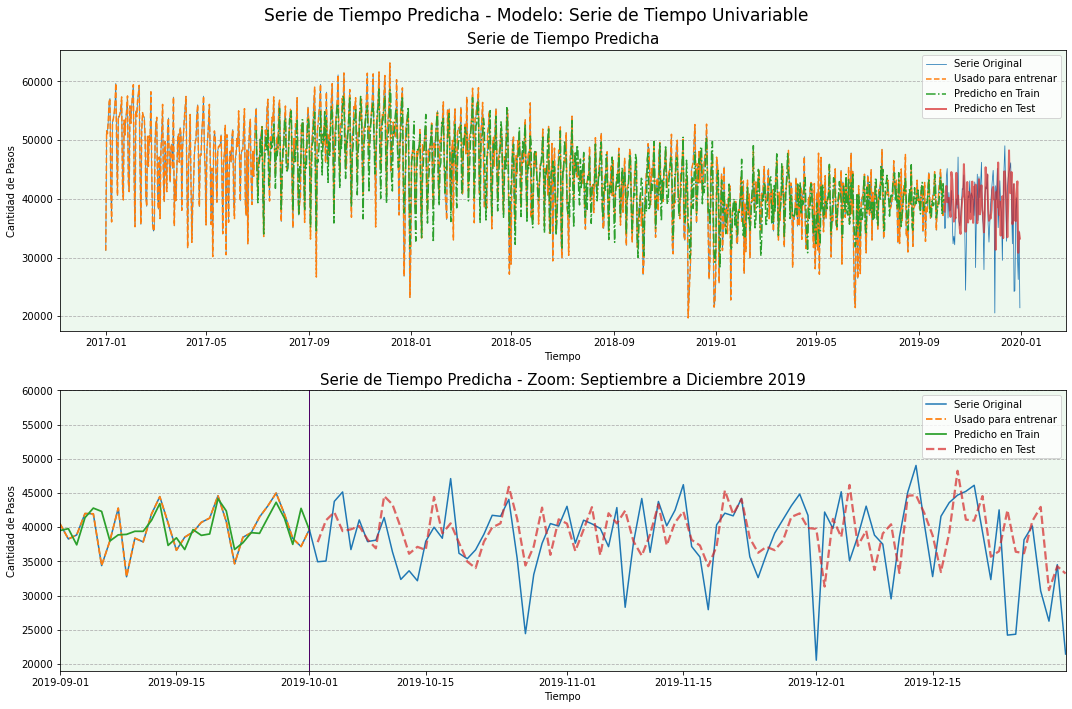

In [33]:
# Preparación de los datos para crear la gráfica. 
senial = df_preprocesado.cantidad_pasos # Dataset con Fechas
length_total = len(train) + len(test) + lookback  # Longitud total del dataset.

#Calculo de las predicciones y sus respectivas transformación inversa. 
y_train_pred_STU = scaler.inverse_transform(model_stu.predict(X_train_STU)) 
y_test_pred_STU = scaler.inverse_transform(model_stu.predict(X_test_STU))

# Graficar serie de tiempo predicha. 
graficar_prediccion(senial, length_total, n_train_days, lookback, y_train_pred_STU, 
                    y_test_pred_STU,'Serie de Tiempo Univariable')

Al contemplar la primer figura, se destaca que el modelo parece adaptarse medianamente bien a los datos originales. Sin embargo, tanto en el conjunto de entrenamiento como en el de prueba, el modelo no logra captar los picos inferiores y superiores de la serie. 
Al corroborar la segunda gráfica, es posible observar que la serie predicha del modelo se aproxima bastante a los datos de entramiento originales. No obstante, no es capaz de captar las caídas abruptas que presenta la serie temporal original para el conjunto de prueba. También se observa que tiende a subestimar los valores superiores de la serie, pero esta diferencia tiende a ser menor.

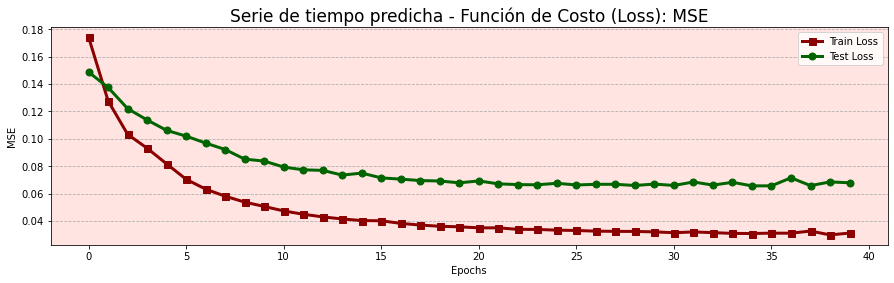

In [34]:
graficar_loss(modelo_1)

Al observar cómo disminuye el valor de perdida MSE (loss) tanto en el conjunto de entrenamiento como en el de prueba, es posible concluir que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y test son distintas.

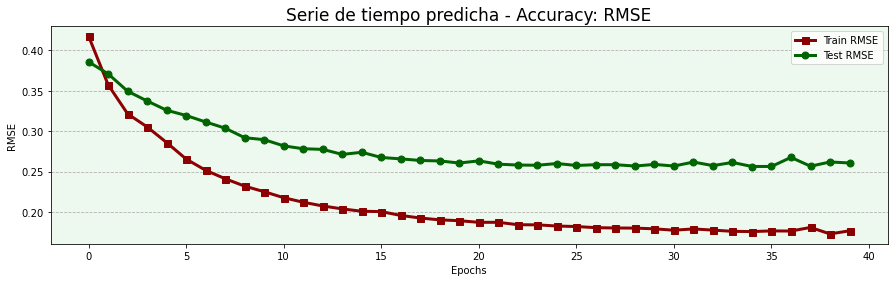

In [35]:
graficar_score(modelo_1)

Con esa gráfica es posible observar como el modelo se adapta mejor al conjunto de entrenamiento que al conjunto de prueba. Sin embargo las diferencias no son demasiado abultadas como para considerar que el mismo se encuentre sobreajustado. 

Se procede a realizar la transformación inversa para obtener los valores predichos y poder compararlos con los valores reales. Luego se procede a calcular la métrica de evaluación (RSME)

In [36]:
erorres_stu = tabla_de_comparacion(y_test_STU, y_test_pred_STU)

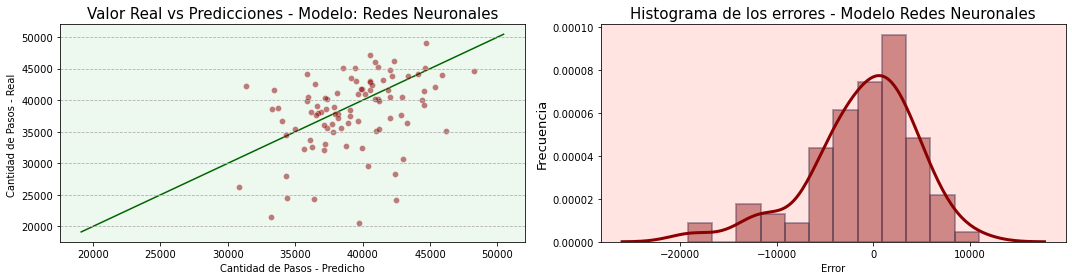

In [37]:
graficar_residuos(erorres_stu)

In [38]:
y_test = scaler.inverse_transform(y_test_STU.reshape(-1,1))
y_test_pred = np.ceil(y_test_pred_STU)

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Test: 5658.0073


#### Conclusiones - Modelo 1: Serie de Tiempo Univariables
Se puede observar que el presente modelo posee ciertos valores que se acercan a la recta que cruza el gráfico de dispersión. Sin embargo, también posee una gran cantidad de residuos por encima y por debajo de ella que reflejan que el modelo no está pudiendo generar predicciones certeras sobre la cantidad de vehículos que van a circular sobre esta autopista en el último trimestre del 2019. 

Asimismo, se observa que al modelo le cuesta predecir cantidades de circulación baja, teniendo un amplio sesgo respecto al valor real. Por el contrario, para los días donde el tránsito es más intenso, el modelo tiende a subestimar la cantidad de vehículos. 

Por último se debe destacar que el modelo presenta un comportamiento similar al de la serie original. Los valores fluctúan entre 30 mil y 45 mil pasos diarios. Donde la mayor cantidad de residuos se conglomeran en torno a +/- 5.000 pasos diarios. A pesar de ello, el RMSE es inferior al obtenido durante el proyecto N°3, donde el modelo optimizado obtuvo un valor de 4220,21 para esta misma métrica.

### Modelo N°2: Serie de Tiempo con múltiples variables (STMV)
Con este segundo modelo se intentará enriquecer a la red neuronal con más entradas. Para ello, se usará el día de la semana y el número de mes como variables categóricas. Para ello, estas variables tomaran valores de entre 0 y 6 para los días de la semana y entre 1 y 12 para el número de mes. 

Con esto se busca que la red intente entender las estacionalidades dadas entre semana y meses.

#### 1. Transformación de los datos de entrada. 
En primer lugar, se procede a agregar el día de la semana y el mes al dataset. Luego se transforman en variables dummies y se transforma su tipo de dato a `float`. Por último, se aplica la transoformación realizada en el modelo anterior para generar el dataset que servirá de input para el modelo de redes neuronales.

In [39]:
df2 = df_preprocesado.copy()
df2['Dia']=[str(x.weekday()) for x in df2.index]
df2['Mes']=[str(x.month) for x in df2.index]
df2.head()

,cantidad_pasos,Dia,Mes
fecha,,,
2017-01-01,31183.0,6,1
2017-01-02,51568.0,0,1
2017-01-03,51093.0,1,1
2017-01-04,53332.0,2,1
2017-01-05,56486.0,3,1


In [40]:
df_dum = pd.get_dummies(df2)
df_dum = df_dum.astype('float32')
print(df_dum.shape)
df_dum.head()

(1095, 20)


,cantidad_pasos,Dia_0,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6,Mes_1,Mes_10,Mes_11,Mes_12,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9
fecha,,,,,,,,,,,,,,,,,,,,
2017-01-01,31183.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,51568.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,51093.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,53332.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,56486.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Transformación de los datos. 
lookback = 180
variables = 20 #Cantidad de variables del dataframe original a utilizar para predecir. 
values = df_dum['cantidad_pasos'].values
values = values.astype('float32')

# Normalización de los valores en el rango (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)

# Se agregan los datos transformados al dataset.
df_dum['scaled'] = scaled
scaledMerge = df_dum.drop('cantidad_pasos', axis=1)

# Aplicamos la función series_to_supervised
reframed = series_to_supervised(scaledMerge, lookback, 1)
reframed.head()

,var1(t-180),var2(t-180),var3(t-180),var4(t-180),var5(t-180),var6(t-180),var7(t-180),var8(t-180),var9(t-180),var10(t-180),...,var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.645430
2017-07-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.193576
2017-07-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030300
2017-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.255006
2017-07-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.257034


#### 2. Separación en conjunto de Entrenamiento y Prueba.

In [42]:
# Se eliminan las columnas que no se van a predecir. 
newReframed = reframed.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 
                             'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 
                             'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 
                             'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)'], axis=1)

# Separación en conjunto de prueba y entrenamiento.
values = newReframed.values
n_train_days = 1095 - (91 + lookback)
train_STMV = values[:n_train_days, :]
test_STMV = values[n_train_days:, :]

# Separación en input y outputs
X_train_STMV, y_train_STMV = train_STMV[:, :-1], train_STMV[:, -1]
X_test_STMV, y_test_STMV = test_STMV[:, :-1], test_STMV[:, -1]

# Reshape input para que sea de 3 dimensiones [samples, timesteps, features] (tensor)
X_train_STMV = X_train_STMV.reshape((X_train_STMV.shape[0], 1, X_train_STMV.shape[1]))
X_test_STMV = X_test_STMV.reshape((X_test_STMV.shape[0], 1, X_test_STMV.shape[1]))
print(X_train_STMV.shape, y_train_STMV.shape, X_test_STMV.shape, y_test_STMV.shape)

(824, 1, 3600) (824,) (91, 1, 3600) (91,)


#### 3. Entrenamos la red neuronal.
Al igual que en el modelo anterior se usarán batches o bloques equivalentes al lookback, es decir, 180 días (reduciendo la necesidad de memoria) y se realizarán 40 vueltas completas (o epochs). Se usarán los datos X_test e y_test para validar el modelo. 

La principal diferencia radica en que este modelo usará 20 variables para predecir la cantidad de pasos diarios en la autopista Illia.

In [43]:
model_STMV = crear_red_neuronal()
modelo_2 = model_STMV.fit(X_train_STMV, y_train_STMV, 
                          epochs = EPOCHS, 
                          validation_data = (X_test_STMV,y_test_STMV), 
                          batch_size = lookback)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 50)             180050    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 180,101
Trainable params: 180,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
5/5 [==============================] - 2s 335ms/step - loss: 0.4518 - root_mean_squared_error: 0.6706 - val_loss: 0.7096 - val_root_mean_squared_error: 0.8424
Epoch 2/40
5/5 [==============================] - 0s 36ms/step - loss: 0.6115 - root_mean_squared_error: 0.7820 - val_loss: 0.8045 - val_root_mean_squared_error: 0.8969
Epoch 3/40
5/5 [=======================

#### 4. Visualización de los resultados obtenidos.
A partir de las funciones antes definidas se procede a graficar los resultados obtenidos por el modelo multivariable (STMV)

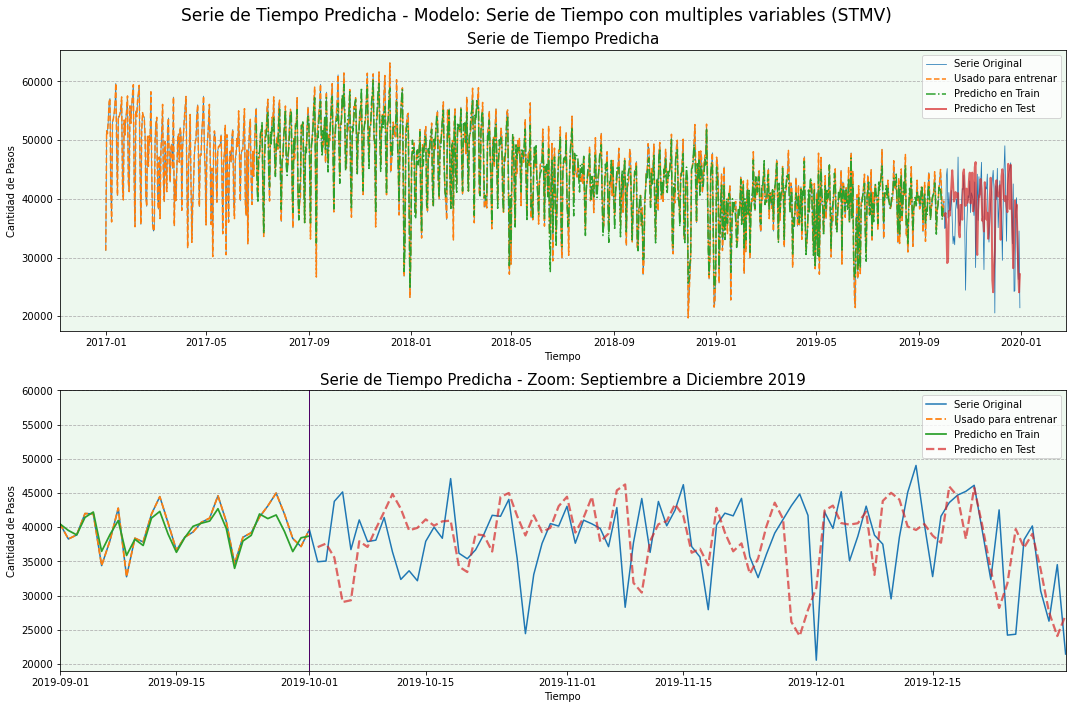

In [44]:
#Calculo de las predicciones y sus respectivas transformación inversa. 
y_train_pred_STMV = scaler.inverse_transform(model_STMV.predict(X_train_STMV)) 
y_test_pred_STMV = scaler.inverse_transform(model_STMV.predict(X_test_STMV))

# Graficar serie de tiempo predicha. 
graficar_prediccion(senial, length_total, n_train_days, lookback, y_train_pred_STMV, 
                    y_test_pred_STMV,'Serie de Tiempo con multiples variables (STMV)')

En estas figuras se puede observar como el modelo continúa presentando ciertas dificultades para predecir la cantidad de pasos diarios. 
Al analizar la primer figura se puede tener la impresión de que el modelo se ajusta bien a los datos reales. Sin embargo al hacer un zoom sobre los últimos meses de 2019, se puede observar que la misma se adapta relativamente bien al conjunto de entrenamiento. Pero, este modelo falla al ver los datos nunca vistos. Se detecta que el modelo tiende, en algunos casos, a anticipar las caídas y subidas en el flujo vehicular. 
El aspecto positivo de este modelo radica en que el mismo tiende a captar mejor las caídas y subidas bruscas de la serie base, por lo cual se podría concluir que al incluir las variables categóricas el modelo ha aprendido mejor sobre estas estacionalidades.

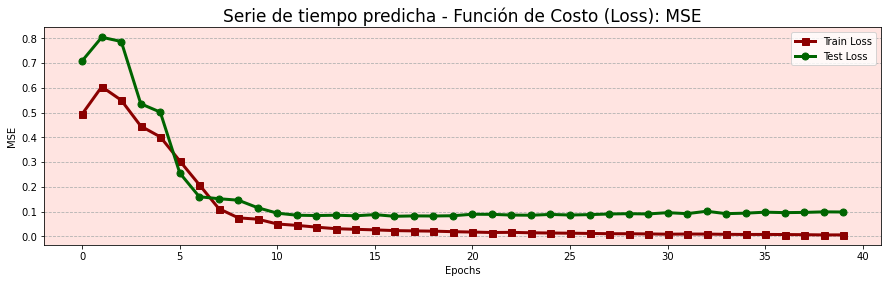

In [45]:
graficar_loss(modelo_2)

Al analizar las curvas de la función de costo, se observa que el modelo se encuentra aprendiendo a medida que avanzan sus repeticiones. Además, su aprendizaje para los datos nunca visto queda apenas por encima de lo obtenido para el conjunto de entrenamiento. Sin embargo, el mismo tiende a estancarse luego del epoch 15, por lo que puede concluirse que la función de costo ha encontrado un mínimo global para este modelo. 

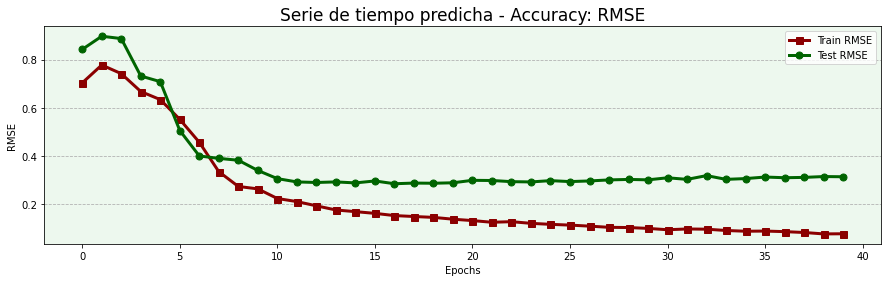

In [46]:
graficar_score(modelo_2)

Al igual que la función de costo, la métrica de evaluación tiende a disminuir a medida que el epoch se aumenta. No obstante, se destaca que, para el conjunto de prueba la disminución en la curva tiende a estancarse en el rango 0.3 mientras que para el conjunto de entrenamiento continúa un comportamiento asintótico al origen. Esto podría interpretarse como una señal de sobreajuste para tener en cuenta.

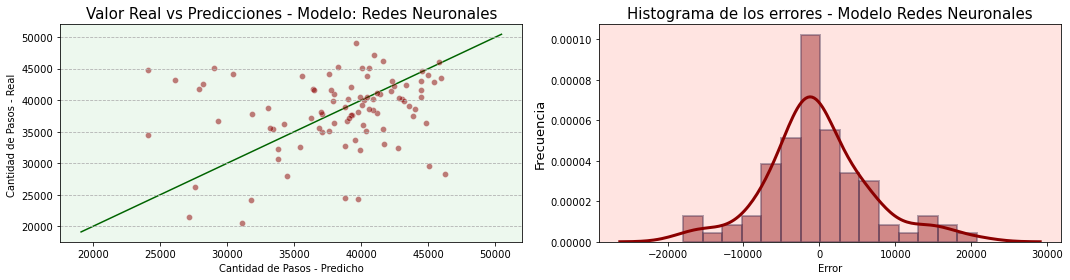

In [47]:
erorres_stmv = tabla_de_comparacion(y_test_STMV, y_test_pred_STMV)
graficar_residuos(erorres_stmv)

In [48]:
y_test_STMV = scaler.inverse_transform(y_test_STMV.reshape(-1,1))
y_test_pred_STMV = np.ceil(y_test_pred_STMV)
MSE_STMV = mean_squared_error(y_test_STMV, y_test_pred_STMV)
RMSE_STMV = np.sqrt(MSE_STMV)
print('Error en Test:', RMSE_STMV)

Error en Test: 6808.4688


#### Conclusiones - Modelo N°2: Serie de Tiempo con múltiples variables (STMV)

Al igual que lo que sucede en el modelo anterior, se puede observar que algunos valores se acercan a la recta que cruza el gráfico de dispersión. Sin embargo, también posee una gran cantidad de residuos por encima y por debajo de ella que reflejan que el modelo no está pudiendo generar predicciones certeras sobre la cantidad de vehículos que van a circular sobre esta autopista en el último trimestre del 2019. 

Incluso se debe destacar que la dispersión de estos valores es mayor a la obtenida en el Modelo N°1. Esto queda también resaltado por el valor obtenido en la métrica de evaluación (RMSE). El RSME obtenido con este modelo ha resultado ser superior respecto al generado tanto en el Modelo N°1 cómo en el Bosque Aleatorio optimizado del Proyecto N°3 (el cual ascendía a 4220,21). 

### Conclusiones: 
Ante lo desarrollado en el presente proyecto, se puede concluir que los modelos de redes neuronales llevados a cabo no logran generar un aprendizaje adecuado para la predicción de la cantidad de pasos diarios en el peaje de la autopista Arturo Illia. Sin embargo, entre ellos, podría ser conveniente continuar con la optimización del Modelo Univariante (Modelo N°1) o incluso evaluar la posibilidad de incluir otras variables (como el tipo de vehículo o dirección de circulación). 


Respecto a estos modelos se debe destacar que el primero (univariante) ha obtenido un mejor rendimiento pero cierta incapacidad para detectar los picos de la serie temporal. Por el otro lado, el segundo modelo (multivariable) ha logrado captar el comportamiento de los picos de la serie temporal, pero los aplica de forma anticipada lo que genera que tenga una mayor desviación en sus errores. 

Estos inconvenientes llevan a concluir que el incremento de complejidad que implica el desarrollo de redes neuronales no logra incrementar el rendimiento del modelo predictivo en esta serie de tiempo. De esta manera, se recomienda continuar con un modelo `RandomForest` optimizado como el desarrollado en el proyecto N°3.


***

### Referencias: 
-	Jake VanderPlas (2016). *Python Data Science Handbook.* Recuperado de: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
-	Prabhakaran, S. *Time Series Analysis in Python – A Comprehensive Guide with Examples*. Recuperado de: https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
- Utrera Burgal, J. (2018). *Deep Learning básico con Keras (Parte 1)*. Recuperado de: https://enmilocalfunciona.io/deep-learning-basico-con-keras-parte-1/
- Martinez, J. (2020). *¿Qué es un Optimizador y Para Qué Se Usa en Deep Learning?* https://datasmarts.net/es/que-es-un-optimizador-y-para-que-se-usa-en-deep-learning/
- Desconocido. *Capítulo 2. Herramientas de extracción de información: Redes Neuronales.* Recuperado de: https://www.tesisenred.net/bitstream/handle/10803/1455/3.CAPITULO_2.pdf?sequence=5&isAllowed=y
- Boostedml (2020). *Feedforward Neural Networks and Multilayer Perceptrons.* Recuperado de: https://boostedml.com/2020/04/feedforward-neural-networks-and-multilayer-perceptrons.html
- Bagnato, J. I. (2017). *Aprendizaje Profundo: una Guía rápida*. Recuperado de: https://www.aprendemachinelearning.com/aprendizaje-profundo-una-guia-rapida/
- Bagnato, J. I (2018). *Breve Historia de las Redes Neuronales Artificiales.* Recuperado de: https://www.aprendemachinelearning.com/breve-historia-de-las-redes-neuronales-artificiales/
- Bagnato, J. I (2019) *Pronóstico de Series Temporales con Redes Neuronales en Python*. Recuperado de: https://www.aprendemachinelearning.com/pronostico-de-series-temporales-con-redes-neuronales-en-python/
- Bagnato, J. I (2019) *Pronóstico de Ventas con Redes Neuronales – Parte 2*. Recuperado de: https://www.aprendemachinelearning.com/pronostico-de-ventas-redes-neuronales-python-embeddings/
- Brownlee, J. (2019) *How to Convert a Time Series to a Supervised Learning Problem in Python*. Recuperado de:  https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/